In [1]:
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wntr
import wntr_utils
from sklearn.preprocessing import MinMaxScaler
from random import shuffle

In [2]:
# load STREaM data (STREaM is a simulator of end-uses and water demand patterns)
# This dataset contains 3 years of hourly (26280 data points) synthetic demand data 
# for 4 user_classes = ['low','average','high','morning','night']. There are 500 user for each class,
# with the first 10 users having leaks. We need to remove these users for our purposes. 

# load data
all_data_path = './data/allData.txt'
df = pd.read_csv(all_data_path, header=None)

# create headers
user_classes = ['low','average','high','morning','night']
headers = []
for user_class in user_classes:
    suffixes = (('_'+user_class+' ')*400).split() # original
    for suffix, number in zip(suffixes,range(1,401)):
        headers.append('user'+suffix+'_'+'%03d'%number)  
# reverse df and change df columns
df = df.T
df.columns = headers

# remove first 10 of each class (these have leaks, so not useful for our purposes)
users_to_remove = np.array(headers).reshape(-1,10)[::40].ravel().tolist()
df.drop(users_to_remove, axis = 1, inplace = True)
headers = df.columns

# echo
print(df.shape)

(26280, 1950)


In [19]:
# this function creates a hourly pattern of multipliers (up to 26280 hours long) mixing together n (max 1950) patterns
# from the STREaM dataset; it scales within a range (as expected for WNTR/EPANET input)
from sklearn.preprocessing import MinMaxScaler
def create_demand_pattern(df_patterns, n_hours=168, n_mix=50, bound = [0.3,0.9], noise_intensity=0.01):
    cols =df_patterns.columns.to_list()
    shuffle(cols)
    df_patterns = df_patterns[cols]
    s = MinMaxScaler(bound)
    temp=np.squeeze(s.fit_transform(df_patterns.iloc[:n_hours,:n_mix].mean(axis=1).values.reshape(-1,1)))
    dem_pat = temp + np.random.randn(n_hours)*noise_intensity
    return dem_pat

### Original vs modified comparison

In [32]:
# original

# load EPANET model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# save original patterns
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    patterns.append(pat.multipliers)
df_pat_orig = pd.DataFrame(data = patterns).T
df_pat_orig.columns = names

# change duration of simulation
wn.options.time.duration=len(df_pat_orig)*3600
    
# Simulate hydraulics
sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
results_orig = sim.run_sim()


D:\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning:

Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user



In [33]:
# modified (STREaM data)

# load EPANET model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# save original patterns
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    temp = create_demand_pattern(df)
    pat.multipliers = temp
    patterns.append(pat.multipliers)
df_pat_new = pd.DataFrame(data = patterns).T
df_pat_new.columns = names

# change duration of simulation
wn.options.time.duration=len(df_pat_new)*3600
    
# Simulate hydraulics
sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
results_new = sim.run_sim()

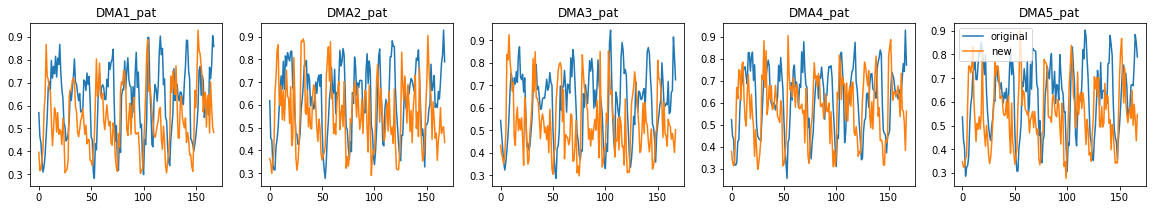

In [34]:
# compare demand patterns
f, axes = plt.subplots(1,5,figsize=(20,3))
for pat_name, ax in zip(names,axes):
    df_pat_orig[pat_name].plot(label='original', ax=ax)
    df_pat_new[pat_name].plot(label='new', ax=ax)
    ax.set_title(pat_name)
ax.legend()
    

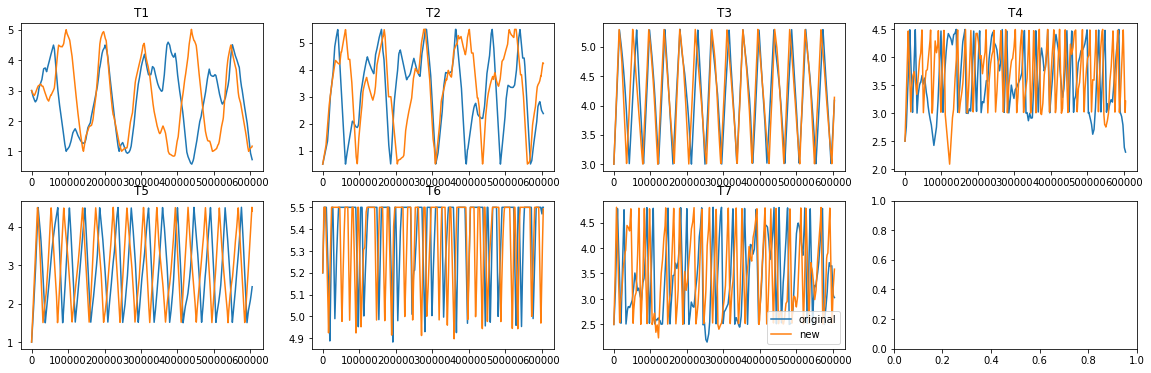

In [35]:
# compare tank levels
tank_names = [tank_name for tank_name, _ in wn.tanks()]
f, axes = plt.subplots(2,4,figsize=(20,6))
for tank_name, ax in zip(tank_names,axes.reshape(-1)):
    results_orig.node['pressure'][tank_name].plot(label='original', ax=ax)
    results_new.node['pressure'][tank_name].plot(label='new', ax=ax)
    ax.set_title(tank_name)
ax.legend()

### long simulation

In [36]:
# modified (STREaM data)

# load EPANET model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# save original patterns
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    temp = create_demand_pattern(df, n_hours=1680)
    pat.multipliers = temp
    patterns.append(pat.multipliers)
df_pat_new = pd.DataFrame(data = patterns).T
df_pat_new.columns = names

# change duration of simulation
wn.options.time.duration=len(df_pat_new)*3600
    
# Simulate hydraulics
sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
results_new = sim.run_sim()

D:\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning:

Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user



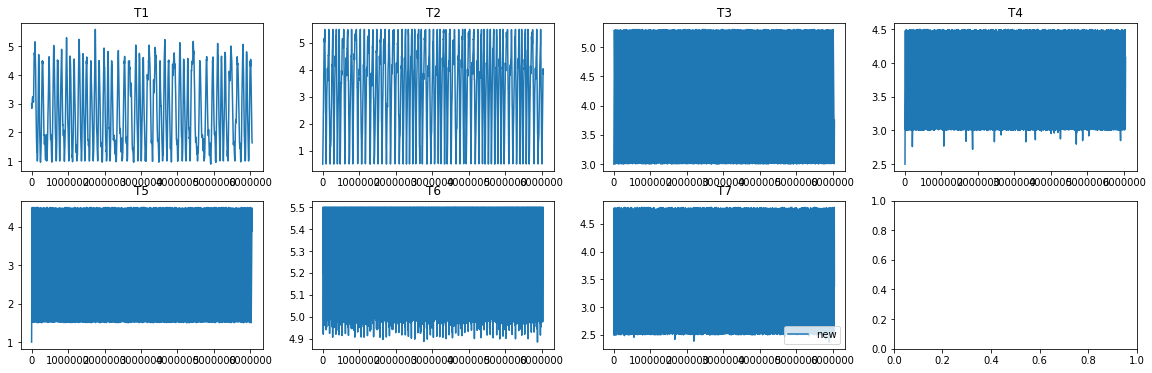

In [37]:
# compare tank levels
tank_names = [tank_name for tank_name, _ in wn.tanks()]
f, axes = plt.subplots(2,4,figsize=(20,6))
for tank_name, ax in zip(tank_names,axes.reshape(-1)):
    results_new.node['pressure'][tank_name].plot(label='new', ax=ax)
    ax.set_title(tank_name)
ax.legend()